In [1]:
import pandas as pd
from pymongo import MongoClient
import datetime
import numpy as np

# Connect to the MongoDB

In [2]:
def _mongo_connect(host, port, username, password, db):
    if username and password:
        mongo_uri = f"mongodb://{username}:{password}@{host}:{port}/{db}"
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)

    return conn[db]


# Connect to MongoDB
db = _mongo_connect(
    host="localhost", port=27017, username=None, password=None, db="tweets"
)

# Get samples to explore data schema

In [24]:
from typing import List, Dict
from pprint import pprint

class Samples(object):
    def __init__(self, db, collection, number_samples):
        self.db = db
        self.collection = collection
        self.data = list(db[collection].aggregate([{"$sample": {"size": number_samples}}]))
    
    @property
    def print_schema_tweet(self):
        for index, tweet in enumerate(self.data):
            if tweet['text'][:2] != 'RT':
                print(index)
                print()
                pprint(tweet)
                break
    @property
    def print_schema_retweet(self):
        for index, tweet in enumerate(self.data):
            if tweet['text'][:2] == 'RT':
                print(index)
                print()
                pprint(tweet)
                break

In [26]:
samples = Samples(db, 'covid2', 100)

In [27]:
samples

# Get tweets text and export in .txt

In [28]:
pipeline = [{"$sample": {"size": 1000}}, 
            {"$project": {"_id": 0, "created_at": 1, "text": 1, "extended_tweet.full_text": 1, 'retweeted_status.extended_tweet.full_text': 1}},
            {"$set": {"full_text": "$extended_tweet.full_text", "retweet_text": '$retweeted_status.extended_tweet.full_text'}},
            {"$unset": ["extended_tweet", "retweeted_status"]}
           ]

samples = list(db.covid2.aggregate(pipeline))

In [29]:
twitter_sample = pd.DataFrame(samples)

In [37]:
def get_full_text(df):
    df.loc[df.full_text.notnull(), 'text'] = df.loc[df.full_text.notnull(), 'full_text']
    df.loc[df.retweet_text.notnull(), 'text'] = df.loc[df.retweet_text.notnull(), 'retweet_text']
    df = df.drop(['full_text', 'retweet_text'], axis=1)
    return df

In [38]:
tweets_text = get_full_text(twitter_sample)

In [ ]:
twitter_sample.text.to_csv('sample.txt', sep=' ', index=False)

# Visualization of time repartition of the tweets

In [41]:
twitter_sample['dates'] = pd.to_datetime(twitter_sample.created_at)

In [42]:
retrieved = twitter_sample.dates.groupby(twitter_sample.dates.dt.to_period('D')).agg('count')

/home/kyd/.virtualenvs/twitter-process-env/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


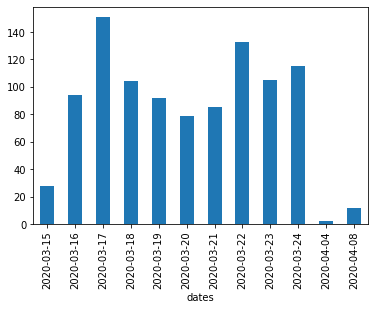

In [43]:
retrieved.plot(kind='bar')